### Fig DESeq Summary (Fig. 5)
- 5A: Scatterplot to show correlation between depleted and input quantseq
- 5B: MA plot of depleted vs. input quant-seq
- 5C: Bar plot for complementarity to the probes for genes going down + depletion vs other genes.

In [2]:
#Imports
import sys
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import os
import gffutils
import seaborn as sns
import numpy as np
import scipy.stats
import itertools
import matplotlib.ticker as plticker

sys.path.append('../scripts/')
from plot_helpers import *

%matplotlib inline
%load_ext autoreload
%autoreload 2

db = gffutils.FeatureDB(gffutils_db)

In [3]:
#Load gene biotypes:
biotype_dict = {}
for i in db.all_features(featuretype = 'gene'):
    this_gene = i.id
    try:
        biotype = db[this_gene].attributes['gene_biotype'][0]
        genename = db[this_gene].attributes['gene_name'][0]
        #change biotype to rRNA if rRNA is in the name -- occurs for some pseudogenes
        if 'rRNA' in genename:
            biotype = 'rRNA'
            
    except KeyError:
        biotype = 'spike-in' #only the spike-ins don't have a biotype
        
    biotype_dict[this_gene] = biotype

In [4]:
#Make outdir and load the data
#Calculate the Pearson r2 between the mean counts for depleted and input Quantseq libraries
outdir = '../figures/F5/'
os.makedirs(outdir, exist_ok = True)
quant_file = os.path.join(results_dir, 'rnaseq_data_200424/results/gene_quantification/summary_abundance_by_gene.csv')
df = pd.read_csv(quant_file)

#Drop the SIRV, spikein values
nospike_df = df[~df['gene'].apply(lambda x: x.startswith('SIRV'))].copy().set_index('gene')

mean_df = nospike_df.groupby(['gene', 'experiment']).mean()
mean_df.reset_index('experiment', inplace = True)

#Get the input and subtracted values, put back together
in_df = mean_df.loc[mean_df['experiment'] == 'inputq', 'summed_tpm'].copy()
sub_df = mean_df.loc[mean_df['experiment'] == 'subtractedq', 'summed_tpm'].copy()
comp_df = pd.merge(in_df, sub_df, left_index = True, right_index = True, suffixes = ('_in', '_sub'))
#restrict to genes with mean TPM >= 1
filtered_df = comp_df[(comp_df['summed_tpm_in'] >= 1) & (comp_df['summed_tpm_sub'] >= 1)].copy()
filtered_df['summed_tpm_in_log10'] = filtered_df['summed_tpm_in'].apply(np.log10)
filtered_df['summed_tpm_sub_log10'] = filtered_df['summed_tpm_sub'].apply(np.log10)
filtered_df['biotype'] = filtered_df.index.map(biotype_dict)

#get data specifically from protein coding and ncRNAs:
coding_ncRNA = ['protein_coding', 'ncRNA']
filtered_df['coding_ncRNA'] = filtered_df['biotype'].isin(coding_ncRNA)
cfilt_df = filtered_df[filtered_df['coding_ncRNA']].copy()

rval, pval = scipy.stats.pearsonr(cfilt_df['summed_tpm_in'], cfilt_df['summed_tpm_sub'])
r2_val = rval**2
print('r2 val from averages', r2_val)

r2 val from averages 0.9728855731106985


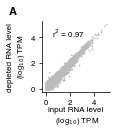

In [5]:
#Plot the correlation between input and depleted libraries
panel_name = '5A'
plot = Plotter(corners = [0.27, 0.27, 0.6, 0.6], figsize = (sfig, sfig))

plot.nudge_corners(left = True, right = True)

plot.setup_axis()
pointsize = 0.5

plot.ax.scatter(cfilt_df['summed_tpm_in_log10'], cfilt_df['summed_tpm_sub_log10'], s = pointsize)
plot.set_ylabel('depleted RNA level\n (log'r'$_{10}$'') TPM', nudge = (0.015, 0))
plot.set_xlabel('input RNA level\n (log'r'$_{10}$'') TPM')
loc = plticker.MultipleLocator(base=2.0)
plot.ax.xaxis.set_major_locator(loc)
plot.ax.yaxis.set_major_locator(loc)

plot.ax.set_xlim(-0.25, 5.3)
plot.ax.set_xlim(-0.25, 5.3)
plot.ax.text(0.5, 4, 'r'r'$^2$'' = %1.2f' % r2_val, fontsize = 8)
plot.add_letter('A', ha = 'right')
plt.savefig(os.path.join(outdir, '{}.png'.format(panel_name)), dpi = 600)

In [176]:
#Get the r2 values between subtracted and input for each replicate
exps = ['inputq', 'subtractedq']
reps = ['rep1', 'rep2', 'rep3']
#get data specifically from protein coding and ncRNAs:
nospike_df['biotype'] = nospike_df.index.map(biotype_dict)
nospike_df['coding_ncRNA'] = nospike_df['biotype'].isin(coding_ncRNA)
cnc_df = nospike_df[nospike_df['coding_ncRNA']].copy()

rep_df = cnc_df.set_index(['experiment', 'replicate'], append = True)

#Get r**2 for depleted vs. input samples at each replicate
for r in reps:
    print(r)
    x_df = rep_df.loc[pd.IndexSlice[:, exps[0], r], 'summed_tpm'].reset_index(['experiment', 'replicate'])
    y_df = rep_df.loc[pd.IndexSlice[:, exps[1], r], 'summed_tpm'].reset_index(['experiment', 'replicate'])
    c_df = pd.merge(x_df, y_df, left_index = True, right_index = True, suffixes = ('_in', '_sub'))
    f_df = c_df[(c_df['summed_tpm_in'] >= 1) & (c_df['summed_tpm_sub'] >= 1)].copy()
    rval, pval = scipy.stats.pearsonr(f_df['summed_tpm_in'], f_df['summed_tpm_sub'])
    r2_val = rval**2
    print(r2_val)

rep1
0.9773366893646647
rep2
0.9500704601446033
rep3
0.9764984841010852


In [178]:
#Get the interreplicate r2 values
for e in exps:
    print('experiment: %s' % e)
    for c in itertools.combinations(reps, 2):
        print('%s\t%s' % (c[0], c[1]))
        x_df = rep_df.loc[pd.IndexSlice[:, e, c[0]], 'summed_tpm'].reset_index(['experiment', 'replicate'])
        y_df = rep_df.loc[pd.IndexSlice[:, e, c[1]], 'summed_tpm'].reset_index(['experiment', 'replicate'])
        c_df = pd.merge(x_df, y_df, left_index = True, right_index = True, suffixes = ('_in', '_sub'))
        f_df = c_df[(c_df['summed_tpm_in'] >= 1) & (c_df['summed_tpm_sub'] >= 1)].copy()
        rval, pval = scipy.stats.pearsonr(f_df['summed_tpm_in'], f_df['summed_tpm_sub'])
        r2_val = rval**2
        print(r2_val)

experiment: inputq
rep1	rep2
0.9749214646593681
rep1	rep3
0.974606576586441
rep2	rep3
0.926387371299923
experiment: subtractedq
rep1	rep2
0.990996679628189
rep1	rep3
0.9708609185001218
rep2	rep3
0.9509357775373605


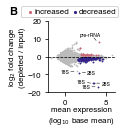

In [7]:
#Fig 5B, plot the results of the DESeq2 analysis
#https://stackoverflow.com/questions/18773662/python-scatter-plot-logarithmic-scale
panel_name = '5B'

sm_rrnas = ['FBgn0085802', 'FBgn0267501', 'FBgn0267498']
lg_rrnas = ['FBgn0267497', 'FBgn0267504']
pre_rrnas = ['FBgn0267506']

deseq_file = os.path.join(results_dir, 'rnaseq_data_200424/results/diffexp/subtractedq-vs-inputq.diffexp.csv')
deseq_df = pd.read_csv(deseq_file, index_col = 0)
deseq_df['log10_baseMean'] = deseq_df['baseMean'].apply(np.log10)

padj_threshold = 0.01
deseq_df['increased'] = (deseq_df['log2FoldChange'] > 0) & (deseq_df['padj'] < padj_threshold)
deseq_df['decreased'] = (deseq_df['log2FoldChange'] < 0) & (deseq_df['padj'] < padj_threshold)

#make space for the legend
#plot = Plotter(corners = [0.27, 0.27, 0.6, 0.6], figsize = (sfig, sfig))
plot = Plotter(corners = [0.32, 0.27, 0.6, 0.6], figsize = (sfig, sfig))

plot.nudge_corners(left = True, right = True)
plot.setup_axis()

pointsize = 0.5
bg = plot.ax.scatter('log10_baseMean', 'log2FoldChange', data = deseq_df, s = pointsize)
up = plot.ax.scatter('log10_baseMean', 'log2FoldChange', data = deseq_df[deseq_df['increased']],
                     s = pointsize, color = color_dict['rose'])

down = plot.ax.scatter('log10_baseMean', 'log2FoldChange', data = deseq_df[deseq_df['decreased']],
                     s = pointsize, color = color_dict['indigo'])
plot.ax.axhline(y = 0, color = 'k', linestyle = '--')
plot.ax.set_ylim(-20, 20)

for g in lg_rrnas:
    x = deseq_df.loc[g, 'log10_baseMean']
    y = deseq_df.loc[g, 'log2FoldChange']
    plot.ax.annotate('28S', xy=(x + 0.15, y), xytext=(x + 1, y), bbox=dict(boxstyle='square,pad=-0.07', fc='none', ec='none'), ha = 'left', va = 'center', fontsize = 5, arrowprops=dict(arrowstyle = '-', connectionstyle = 'arc3', linewidth = 0.5))

for g in sm_rrnas:
    x = deseq_df.loc[g, 'log10_baseMean']
    y = deseq_df.loc[g, 'log2FoldChange']
    if g == 'FBgn0085802':        
        plot.ax.annotate('18S', xy=(x - 0.15, y + 0.05), xytext=(x - 1, y + 1),  bbox=dict(boxstyle='square,pad=-0.07', fc='none', ec='none'),fontsize = 5, va = 'center', ha = 'right', arrowprops=dict(arrowstyle = '-', connectionstyle = 'arc3', linewidth = 0.5))
    else:
        plot.ax.annotate('18S', xy=(x - 0.15, y), xytext=(x - 1, y),  bbox=dict(boxstyle='square,pad=-0.07', fc='none', ec='none'),fontsize = 5, va = 'center', ha = 'right', arrowprops=dict(arrowstyle = '-', connectionstyle = 'arc3', linewidth = 0.5))

for g in pre_rrnas:
    x = deseq_df.loc[g, 'log10_baseMean']
    y = deseq_df.loc[g, 'log2FoldChange']  
    plot.ax.annotate('pre-rRNA', xy=(x - 0.15, y + 0.15), xytext=(x - 1, y + 3), bbox=dict(boxstyle='square,pad=-0.07', fc='none', ec='none'), ha = 'center', va = 'bottom', fontsize = 5, arrowprops=dict(arrowstyle = '-', connectionstyle = 'arc3', linewidth = 0.5))

plot.ax.legend([up, down, bg], ['increased', 'decreased'], ncol = 2, bbox_to_anchor=(-0.41, 1.1, 1.45, .102),
               fontsize = 8, borderpad = 0.2, borderaxespad=0., labelspacing = 0, handletextpad = -0.5, mode = 'expand', markerscale = 3)

ytext =  'log'r'$_{2}$' ' fold change\n(depleted / input)'
xtext = 'mean expression\n(log'r'$_{10}$' ' base mean)'
plot.set_xlabel(xtext)
plot.set_ylabel(ytext, nudge = (0.015, 0))
#borderpad effects the box size but it is unevenly distributed - left one is still over on right a bit
plot.add_letter('B', ha = 'right')
plt.savefig(os.path.join(outdir, '{}.png'.format(panel_name)), dpi = 600)

##The targeted transcripts
18S:
FBtr0346874 #FBgn0085802
FBtr0346882 #FBgn0267501
FBtr0346878 #FBgn0267498
28S:
FBtr0346876 #FBgn0267497
FBtr0346885 #FBgn0267504

an untargeted pre-rRNA that is changing a lot:
FBgn0267506

In [14]:
#Assign genes to biotype
deseq_df['biotype'] = deseq_df.index.map(biotype_dict)
#Remove rRNAs and spike-ins from this analysis as they are not relevant genes for this analysis
deseq_df2 = deseq_df[(deseq_df['biotype'] != 'rRNA') & (deseq_df['biotype'] != 'spike-in')].dropna(subset = ['log2FoldChange']).copy()
print('number non-zero genes', len(deseq_df2))

number non-zero genes 14852


In [15]:
#Report number and fold-change of increasing and decreasing genes
decreased_df = deseq_df2[deseq_df2['decreased']].copy()
increased_df = deseq_df2[deseq_df2['increased']].copy()

print('num increased', len(increased_df))
print('med increased', 2**increased_df['log2FoldChange'].median())
print('num decreased', len(decreased_df))
print('med decreased', 2**decreased_df['log2FoldChange'].median())
print('med decreased fold-change', 1/2**decreased_df['log2FoldChange'].median())

num increased 30
med increased 1.8881352250656875
num decreased 217
med decreased 0.4561820734973569
med decreased fold-change 2.1921071828478897


In [16]:
#Fig 5B, quantifying probe matches of downregulated genes vs. other genes
def get_count_table(df, value, category):
    '''
    Return a dataframe containing counts of
    a specific value. For example length or bitscore.
    Create a column labeled category with the name for the bar plot
    '''
    count_s = df[value].value_counts().to_frame().rename(columns = {value:'counts'})
    count_df = pd.DataFrame(count_s)
    count_df['percent_counts'] = (count_df['counts']/count_df['counts'].sum())*100
    count_df[value] = count_df.index
    label = '%s\n(n = %s)' % (category, count_df['counts'].sum())
    count_df['category'] = label
    return count_df, label

def add_gene(x):
    if x.startswith('FBg'):
        gene = x.split('_')[0]
    else:
        gene = next(db.parents(x, featuretype = 'gene')).id
    return gene

In [17]:
#Fig 5C, plot the alignment scores of all genes vs. the decreasing genes
down_genes = decreased_df.index
lengths_used = [12, 13, 14, 15]

homol_file = os.path.join(results_dir, 'probe_design_results/dmel_homology/Dmel_probe_blast_e500.csv')
homol_df = pd.read_csv(homol_file, names = ['qseqid', 'sseqid', 'pident', 'length',
    'mismatch', 'gapopen', 'qstart', 'qend', 'sstart', 'send', 'evalue', 'bitscore'])

#extract the minus strand alignments, since this would indicate potential probe hyb
homol_df['strand'] = homol_df.apply(lambda x: 'plus' if x['send'] > x['sstart'] else 'minus', axis = 1)
minus_homol_df = homol_df[homol_df['strand'] == 'minus'].copy()
#add gene symbol
minus_homol_df['gene'] = minus_homol_df['sseqid'].apply(add_gene)
#count matches to decreased transcripts vs. all other transcripts
lengths_used = [12, 13, 14, 15]
minus_homol_df['down'] = minus_homol_df['gene'].isin(down_genes)
ident_df = minus_homol_df[minus_homol_df['pident'] == 100].copy()
ident_df = ident_df.loc[ident_df['length'].isin(lengths_used)].copy()
txt_count_down, txt_down_label = get_count_table(ident_df[ident_df['down']], 'length', 'decreased genes')
txt_count_other, txt_other_label = get_count_table(ident_df[~ident_df['down']], 'length', 'other genes')
txt_count_df = pd.concat([txt_count_down, txt_count_other])

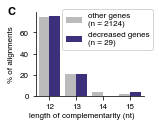

In [18]:
#Plot matches in genome of matches to genes decreased after depletion vs. other genes
panel_name = '5C'

plot = Plotter(corners = [0.19, 0.24, 0.71, 0.71], figsize = (sfig*1.3, sfig))
plot.nudge_corners(left = True)
plot.setup_axis()

plot.ax = sns.barplot(x = 'length', y = 'percent_counts', 
                      hue_order = [txt_other_label, txt_down_label], 
                      hue = 'category', data = txt_count_df, 
                      palette = [color_dict['grey'], color_dict['indigo']], 
                      ax = plot.ax)

plot.set_ylabel('% of alignments')
plot.set_xlabel('length of complementarity (nt)', nudge = (-0.05, 0))

leg = plot.ax.get_legend().set_visible(False)
plot.ax.legend(loc = 3, ncol = 1, fontsize = label_fontsize, bbox_to_anchor=(0.21, 0.5, 1.45, .102))
plot.add_letter('C')
plt.savefig(os.path.join(outdir, '{}.png'.format(panel_name)), dpi = 600)

In [19]:
txt_count_df

,counts,percent_counts,length,category
12,22,75.862069,12,decreased genes\n(n = 29)
13,6,20.689655,13,decreased genes\n(n = 29)
15,1,3.448276,15,decreased genes\n(n = 29)
12,1578,74.293785,12,other genes\n(n = 2124)
13,436,20.527307,13,other genes\n(n = 2124)
14,72,3.389831,14,other genes\n(n = 2124)
15,38,1.789077,15,other genes\n(n = 2124)


In [20]:
#We're getting exact matches of lowest length tested for every probe, so we have set E-value cutoff high enough
len(ident_df.loc[ident_df['length'] == 12, 'qseqid'].unique())

15